In [1]:
%pylab
%matplotlib inline
import healpy as hp
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun
from functools import reduce
import pandas as pd

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Frequency extrapolation

In [2]:
path_new='/Users/michellemora/Documents/Universidad/9/Germanchou/Gain_MIST/Gains-'
path='/Users/michellemora/Documents/Universidad/9/Germanchou/Gain_MIST_Oscar/Gain_theta_phi_'

In [3]:
T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/michellemora/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


Temperature spectral index
    
$$\alpha=-\frac{log(T_1/T_2)}{log(\nu_1/\nu_2)}$$

In [4]:
def T_freq(alpha,freq1,freq2,T1):
    return T1*10**(alpha*log10(freq1/freq2))

### Galactic longitude (l) and latitude (b)

In [5]:
nside = hp.get_nside(T_Hmap)  #nside
npix = hp.nside2npix(nside)   #number of pixels

l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel
g_coord=SkyCoord(l*u.deg, b*u.deg, frame='galactic')  

### Time and location for horizontal coordinates 

In [6]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

times30=start_t + TimeDelta(30*60, format='sec')*linspace(0,48,48) #dt=30 min

altaz30 = AltAz(location=Alma_loc, obstime=times30)

### Dynamic Spectra

Temperature matrix for the dynamic spectra

$$T(\nu,t)=\begin{pmatrix}
T(\nu_1,t_m) & T(\nu_2,t_m) & \cdots & T(\nu_n,t_m)\\ 
 \vdots &  \vdots  &\vdots & \vdots  \\ 
T(\nu_1,t_1) & T(\nu_2,t_1) & \cdots & T(\nu_n,t_1)
\end{pmatrix}$$

### Antenna gain files

$$g_{\nu}=g_{\nu}(\theta,\phi)$$

$$g_{\nu}(\theta,\phi)=\begin{pmatrix}
g_{\nu}(\theta=0,\phi=0) & g_{\nu}(\theta=0,\phi=1) & \cdots & g_{\nu}(\theta=0,\phi=359)\\ 
g_{\nu}(\theta=1,\phi=0) & g_{\nu}(\theta=1,\phi=1) & \cdots & g_{\nu}(\theta=1,\phi=359)\\
 \vdots &  \vdots  &\vdots & \vdots  \\ 
g_{\nu}(\theta=90,\phi=0) & g_{\nu}(\theta=90,\phi=1) & \cdots & g_{\nu}(\theta=90,\phi=359)\\
\end{pmatrix}$$

In [7]:
f=arange(40,121,1)

### $G[\nu,\theta,\phi]$ Matrix

In [8]:
#Sort files in right order

#for i in range (len(f)):
#    file='{}{}{}'.format(path, f[i], "MHz.csv")
#    x=loadtxt(file, skiprows=181,delimiter=',')   #Theta[0:]
#    new=concatenate((x[:91,181:],x[:91,2:181]),axis=1) #Theta[0,90],phi[0,359]
#    savetxt('{}-{}.txt'.format('Gains',f[i]), new)

In [9]:
G_FTP=empty((len(f),91,360))

for i in range (len(f)):
    file='{}{}{}'.format(path_new, f[i], ".txt")
    x=loadtxt(file)
    G_FTP[i]=x

G_n=G_FTP/amax(G_FTP)    #Normalize to the maximum gain value

In [10]:
G_n[0]       #Primera matriz
amax(G_n)    #Máximo de todas las matrices
G_FTP[0,1,0] #Matriz 0 (primera frecuencia), theta=0, phi=1

5.76021544300054

In [11]:
#TEST
th=[0,1,2]
ph=[0,3,0]

G_n[0,th,ph]

array([0.57039743, 0.57001708, 0.56889871])

### Dynamic Spectra with gain pattern $G[\nu,\theta,\phi]$

In [12]:
def Temps_gain_final(fs,ts,alfa):  
    '''Takes frequencies (fs), times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size): 
        
        
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    #Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   #Int value (dTheta=1deg)
        
        phi=aa_coord.az[mask]                                     ##phi's==azimuth
        phi=phi.value.astype(int)                                 ##Int value (dphi=1deg)
        
        for j in range (len(fs)): 
            T_f=T_freq(alfa,408,fs[j],T_sky)                #Extrapolation
            
            gain=G_n[j,Th,phi]/mean(G_n[j,Th,phi])          ##Gains of Th and phi in same order as Tsky  
            
            T_f_g=gain*T_f                                  #New T_sky with respective gain
            Temps_g[-i,j]=mean(T_f_g)                       #Mean temperature (bottom to top)
        
    end = time.time()
    print('Tiempo(min):',(end - start)/60)    
        
      
    return Temps_g

In [13]:
T_G_final_25=Temps_gain_final(f,altaz30,2.5)

Tiempo(min): 13.430615782737732


In [14]:
savetxt('DS+G(theta,phi) alfa=2.5.txt', T_G_final_25)

In [15]:
T_G_final=Temps_gain_final(f,altaz30,2.54)

Tiempo(min): 10.309698629379273


In [16]:
savetxt('DS+G(theta,phi)', T_G_final)

In [17]:
fig1=pd.read_csv('figure1_plotdata.csv',names=['Freq','Weight','Tsky','Tres1','Tres2','Tmodel','T21'],skiprows=4,skipfooter=2,engine='python')
T=loadtxt('DS f(40,110).txt')
T_G=loadtxt('DS+G f(40,110).txt')
T_G_final_cut=T_G_final[:,:71]

horas=linspace(0,24,48)
freqs1=arange(40,111,1)

([[<matplotlib.lines.Line2D at 0x128e7ae10>],
 Text(0.5,0,'freq (MHz)'),
 Text(0,0.5,'T (K)'))

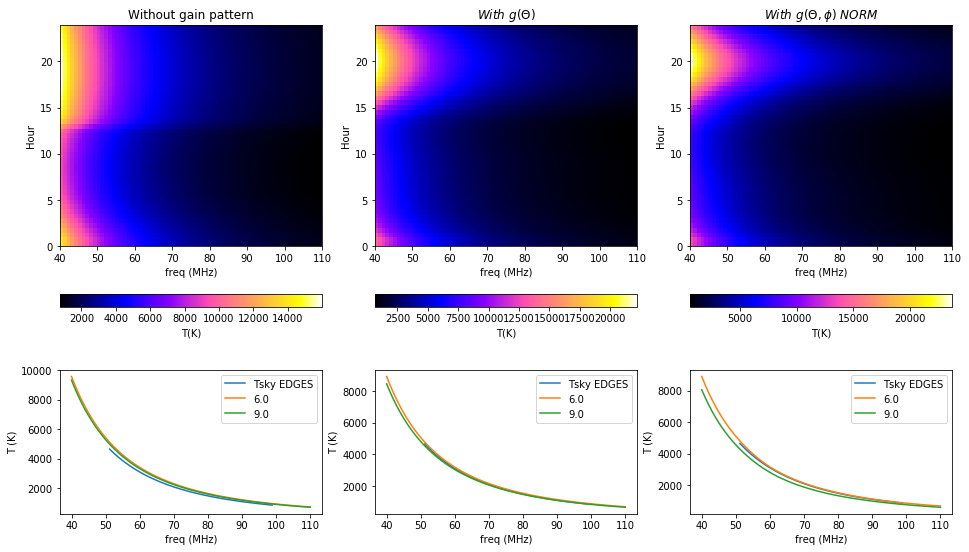

In [18]:
figure(figsize=(16,9))
subplot2grid((3,3), (0,0),rowspan=2)
pcolormesh(freqs1,horas, T,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("Without gain pattern"),xlabel('freq (MHz)'),ylabel('Hour')

subplot2grid((3,3), (0,1),rowspan=2)
pcolormesh(freqs1,horas, T_G,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("$With\ g( \Theta)$"),ylabel('Hour'),xlabel('freq (MHz)')

subplot2grid((3,3), (0,2),rowspan=2)
pcolormesh(freqs1,horas, T_G_final_cut,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("$With\ g( \Theta,\phi)\ NORM$"),ylabel('Hour'),xlabel('freq (MHz)')

subplot2grid((3,3), (2,0))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(freqs1,T[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

subplot2grid((3,3), (2,1))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(freqs1,T_G[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

subplot2grid((3,3), (2,2))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(freqs1,T_G_final_cut[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

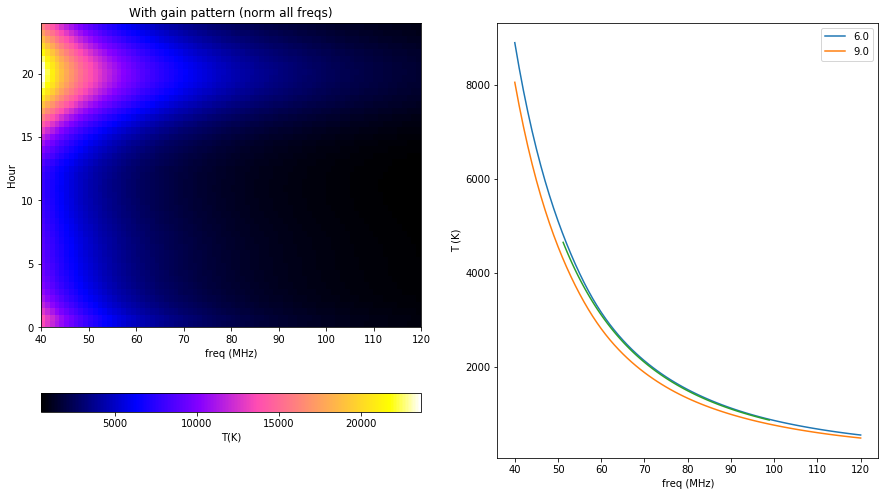

In [19]:
figure(figsize=(15,8))
subplot(1,2,1)
pcolormesh(f,horas, T_G_final,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm all freqs)"),ylabel('Hour'),xlabel('freq (MHz)')
subplot(1,2,2)
[plot(f,T_G_final[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')

### First try (wrong)

### Dynamic Spectra with gain pattern $g=g(\theta,\phi)$

In [ ]:
def Temps_gain_final(fs,ts,alfa):  
    '''Takes frequencies (fs), times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size): 
        
        
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    #Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   #Int value (dTheta=1deg)
        
        phi=aa_coord.az[mask]                                     ##phi's==azimuth
        phi=phi.value.astype(int)                                 ##Int value (dphi=1deg)
        
        
        T_f=T_freq(alfa,408,fs,T_sky)             #Extrapolation
            
        gain=G_n[fs,Th,phi]/mean(G_n[fs,Th,phi])          ##Gains of Th and phi in same order as Tsky  
            
        T_f_g=gain*T_f                            #New T_sky with respective gain
        
        Temps_g[-i,:]=mean(T_f_g)                 #Mean temperature (bottom to top)
        
    end = time.time()
    print('Tiempo(min):',(end - start)/60)    
        
      
    return Temps_g

In [ ]:
T_G_NO=loadtxt('DS+G FINAL.txt')